In [1]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import svd
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from toolbox_02450 import rlr_validate
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, title, subplot, show, grid)
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
import torch
from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary, rlr_validate_mse, rlr_validate_nmo, mcnemar, ttest_twomodels
from scipy import stats
import statsmodels.stats.contingency_tables as tbl
from collections import Counter
import torch.optim as optim

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False  # display “ - ”


data = pd.read_csv('dropout_data.csv', delimiter=';')
data.columns = [col.replace('\t', '') for col in data.columns]
# data_no_target = data.drop(columns=['Target']) # delete target column
# data_matrix = data_no_target.values  # data matrix
# target = data['Target']
# attributeNames = data_no_target.columns.tolist()
# classNames = target.unique().tolist()
# class_num = len(classNames)
# class_name_mapping = {className: index for index, className in enumerate(classNames)}
# target_to_num = [class_name_mapping[className] for className in target] # drop out = 0, graduate = 1, enrolled = 2
# one_hot_encoded = LabelBinarizer().fit_transform(target_to_num)

# # revise partial data according to appendix of reference
# for col_index in [0,1,3,5,7,8,9,10,11]:
#         current_column = data_matrix[:, col_index]
#         unique_values = np.unique(current_column)
#         unique_values.sort()
#         value_to_rank = {value: rank +1 for rank, value in enumerate(unique_values)}
#         data_matrix[:, col_index] = np.vectorize(value_to_rank.get)(current_column)

# revise partial data according to appendix of reference
for col_index in [0,1,3,5,6,7,8,9]:
        current_column = data.values[:, col_index]
        unique_values = np.unique(current_column)
        unique_values.sort()
        value_to_rank = {value: rank +1 for rank, value in enumerate(unique_values)}
        data.values[:, col_index] = np.vectorize(value_to_rank.get)(current_column)



features = data.drop(columns=['Target', 'Previous qualification (grade)', 'Admission grade'])
y = data['Previous qualification (grade)'].values
X = features.values  # Data matrix
attributeNames = features.columns.tolist()
# Normalize data
# X = stats.zscore(X)
# X = data_matrix
# y = X[:, 6]
# X = np.delete(X, 6, axis=1)
# X = np.delete(X, 11, axis=1)
# attributeNames.remove('Previous qualification (grade)')
###############
# regression_b#
###############

In [2]:
N, M = X.shape
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1
K = 10
CV = model_selection.KFold(K, shuffle=True)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))
k=0

z_al_r = []
CI_al_r = []
p_al_r = []

z_ab_r = []
CI_ab_r = []
p_ab_r = []

z_lb_r = []
CI_lb_r = []
p_lb_r = []

for train_index, test_index in CV.split(X,y):
    print('\n ***Outer Crossvalidation fold: {0}/{1}'.format(k+1,K))
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10
    lambdas = np.logspace(-8, 8, 100)

    # receive output
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda, baseline_mse, best_units_num, min_error_ann = rlr_validate_mse(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :]
    device = torch.device('cuda:0')
    
    X_train_ann = torch.Tensor(X_train).to(device)
    y_train_ann = torch.Tensor(y_train).to(device)
    X_test_ann = torch.Tensor(X_test).to(device)
    y_test_ann = torch.Tensor(y_test).to(device)
    y_train_ann = y_train_ann.view(-1,1).to(device)
    y_test_ann = y_test_ann.view(-1,1).to(device)
    

    # ANN
    model = torch.nn.Sequential(
        torch.nn.Linear(M, best_units_num),  # M features to H hidden units
        torch.nn.BatchNorm1d(best_units_num),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(best_units_num, 1),  # H hidden units to 1 output neuron for regression
    ).to(device)
    loss_fn = torch.nn.MSELoss()
    loss_fn = loss_fn.to(device)
    optimizer = optim.Adam(model.parameters(), weight_decay= 0.0005)
    max_iter = 5000
    for iteration in range(max_iter):
        X_batch = X_train_ann
        y_batch = y_train_ann
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    y_test_est_ann = model(X_test_ann).float()
    y_test_ann = y_test_ann
    y_test_est_ann = y_test_est_ann
    error_ann = ((y_test_ann - y_test_est_ann) ** 2).mean()
    
    # Linear Regression
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    y_test_pred = X_test @ w_rlr[:,k].T
    error_lr = ((y_test - y_test_pred) ** 2).mean().item()
    
    # Baseline
    y_mean_train = np.mean(y_train)
    y_pred_baseline = np.full(len(y_test), y_mean_train)
    error_bl = np.mean((y_pred_baseline - y_test) ** 2)
    
    
    # calculate t-test
    z_al, CI_al, p_al = ttest_twomodels(y_test, y_test_est_ann.cpu().data.numpy(), y_test_pred, alpha=0.05, loss_norm_p=1)
    z_ab, CI_ab, p_ab = ttest_twomodels(y_test, y_test_est_ann.cpu().data.numpy(), y_pred_baseline, alpha=0.05, loss_norm_p=1)
    z_lb, CI_lb, p_lb = ttest_twomodels(y_test, y_test_pred, y_pred_baseline, alpha=0.05, loss_norm_p=1)

    z_al_r.append(z_al)
    CI_al_1  = [arr[0] for arr in CI_al] # extract repeated 2 elements
    CI_al_r.append(CI_al_1)
    p_al_r.append(np.mean(p_al))
    
    z_ab_r.append(z_ab)
    CI_ab_1  = [arr[0] for arr in CI_ab] # extract repeated 2 elements
    CI_ab_r.append(CI_ab_1)
    p_ab_r.append(np.mean(p_ab))
    
    z_lb_r.append(z_lb)
    #CI_lb_1  = [arr[0] for arr in CI_lb] # extract repeated 2 elements
    CI_lb_r.append(CI_lb)
    p_lb_r.append(np.mean(p_lb))
    
    print('\n',
        'Optimal Hidden units: {0}'.format(best_units_num), '\n',
        # 'ANN error: {0}'.format(np.mean(min_error_ann)), '\n',
        'ANN error: {0}'.format(error_ann), '\n',
        'Optimal λ: {0}'.format(np.log10(opt_lambda)), '\n',
        'Linear Regression error: {0}'.format(error_lr), '\n',
        'Baseline error: {0}'.format(error_bl), '\n',
        #'Test error without: {0}'.format(Error_test.mean()),'\n',
        #'Test error: {0}'.format(Error_test_rlr.mean()), '\n',        
        )

    k+=1
    
###########################
# regression_b_evaluation #
###########################


 ***Outer Crossvalidation fold: 1/10

 Inner Crossvalidation Fold: 1/10
hidden units number: 1

	ANN loss: 7095.7294921875

hidden units number: 8

	ANN loss: 246.81907653808594

hidden units number: 16

	ANN loss: 160.1439971923828

hidden units number: 32

	ANN loss: 163.1477813720703

hidden units number: 64

	ANN loss: 156.93496704101562

hidden units number: 128

	ANN loss: 159.26771545410156

hidden units number: 256

	ANN loss: 166.88795471191406


 Inner Crossvalidation Fold: 2/10
hidden units number: 1

	ANN loss: 16432.3046875

hidden units number: 8

	ANN loss: 205.71121215820312

hidden units number: 16

	ANN loss: 157.42138671875

hidden units number: 32

	ANN loss: 149.29592895507812

hidden units number: 64

	ANN loss: 142.2653045654297

hidden units number: 128

	ANN loss: 152.44163513183594

hidden units number: 256

	ANN loss: 154.96763610839844


 Inner Crossvalidation Fold: 3/10
hidden units number: 1

	ANN loss: 7270.07763671875

hidden units number: 8

	ANN loss:

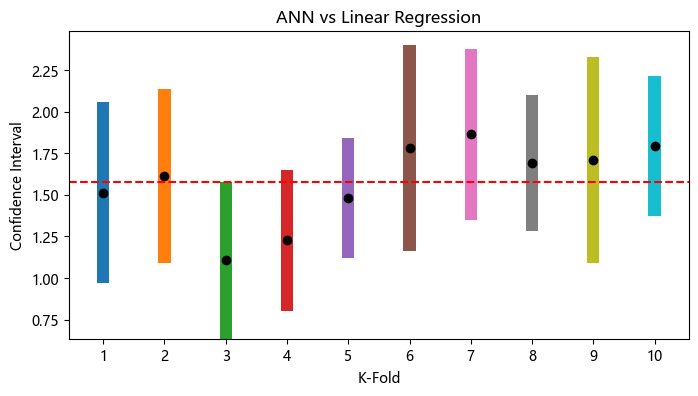

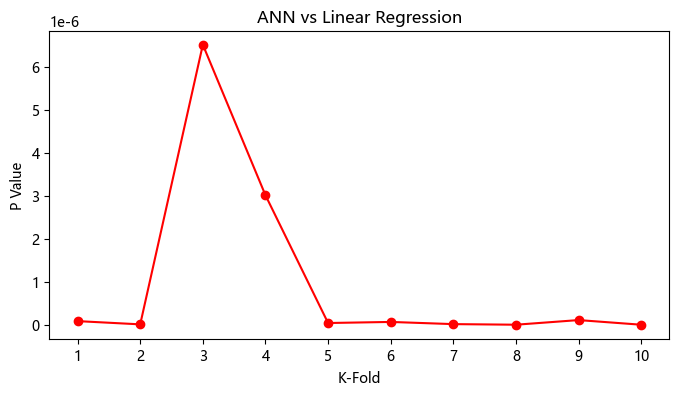

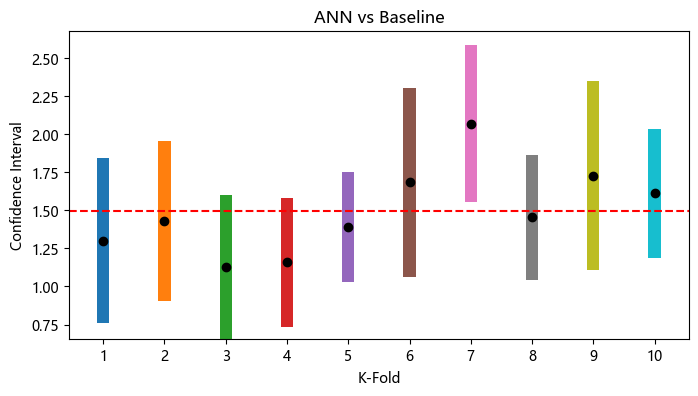

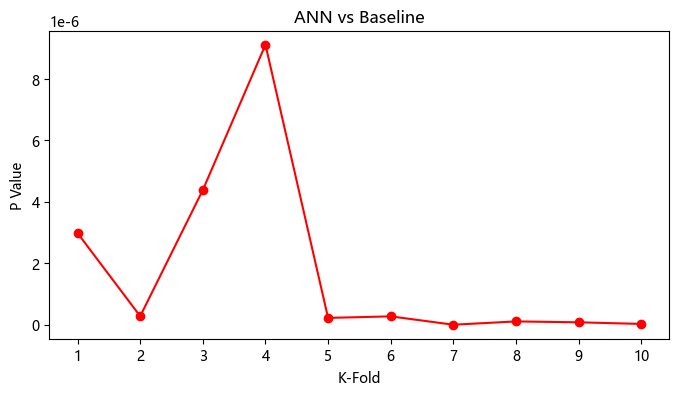

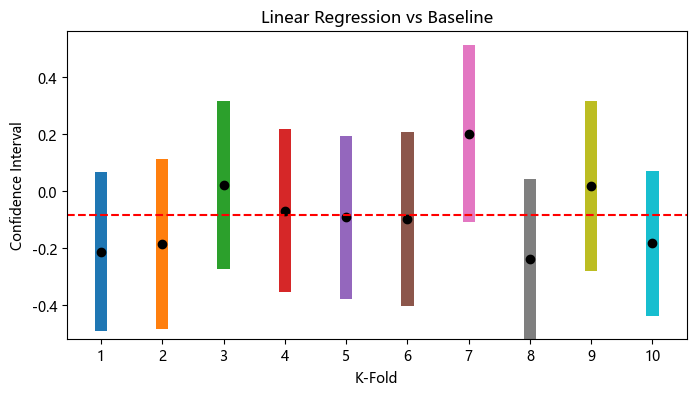

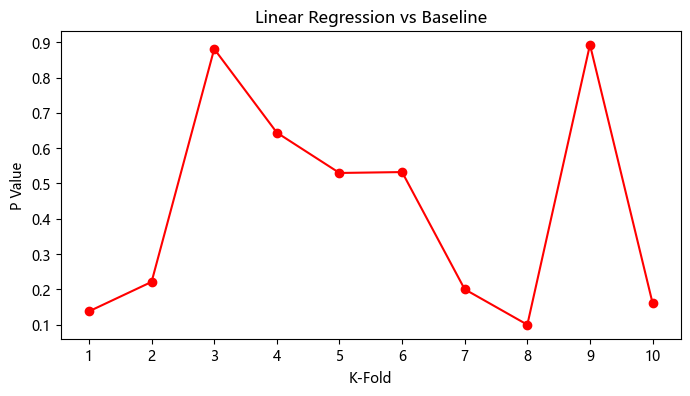

In [3]:
# show ANN vs Linear Regression
lower_bounds_al = [row[0] for row in CI_al_r]
upper_bounds_al = [row[1] for row in CI_al_r]
column_means_al = [sum(row) / len(row) for row in CI_al_r]
center_line1_al = np.mean(np.concatenate([lower_bounds_al, upper_bounds_al]))
x = np.arange(1,K+1)
plt.figure(figsize=(8, 4))
for x, start, end in zip(x, lower_bounds_al, upper_bounds_al):
    plt.bar(x, height=end-start, bottom=start, width = 0.2)
    
plt.scatter(np.arange(1, k+1), column_means_al, color='black', marker='o', label='Mean Value')
plt.axhline(center_line1_al, color='red', linestyle='--', label='mean')
plt.xlabel('K-Fold')
plt.ylabel('Confidence Interval')
plt.title('ANN vs Linear Regression')
plt.xticks(np.arange(1, k+1, 1))
plt.savefig('ANN vs Linear Regression Confidence Interval.pdf', dpi=1000)
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, k+1), p_al_r, marker='o', linestyle='-', color = 'red')
plt.xlabel('K-Fold')
plt.ylabel('P Value')
plt.title('ANN vs Linear Regression')
plt.xticks(np.arange(1, k+1, 1))
plt.savefig('ANN vs Linear Regression P Value.pdf', dpi=1000)
plt.show()

# show ANN vs Baseline
lower_bounds_ab = [row[0] for row in CI_ab_r]
upper_bounds_ab = [row[1] for row in CI_ab_r]
column_means_ab = [sum(row) / len(row) for row in CI_ab_r]
center_line1_ab = np.mean(np.concatenate([lower_bounds_ab,upper_bounds_ab]))
x = np.arange(1,K+1)
plt.figure(figsize=(8, 4))
for x, start, end in zip(x, lower_bounds_ab, upper_bounds_ab):
    plt.bar(x, height=end-start, bottom=start, width = 0.2)
    
plt.scatter(np.arange(1, k+1), column_means_ab, color='black', marker='o', label='Mean Value')
plt.axhline(center_line1_ab, color='red', linestyle='--', label='mean')
plt.xlabel('K-Fold')
plt.ylabel('Confidence Interval')
plt.title('ANN vs Baseline')
plt.xticks(np.arange(1, k+1, 1))
plt.savefig('regression ANN vs Baseline Confidence Interval.pdf', dpi=1000)
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, k+1), p_ab_r, marker='o', linestyle='-', color = 'red')
plt.xlabel('K-Fold')
plt.ylabel('P Value')
plt.title('ANN vs Baseline')
plt.xticks(np.arange(1, k+1, 1))
plt.savefig('regression ANN vs Baseline P Value.pdf', dpi=1000)
plt.show()

# show Linear Regression vs Baseline
lower_bounds_lb = [row[0] for row in CI_lb_r]
upper_bounds_lb = [row[1] for row in CI_lb_r]
column_means_lb = [sum(row) / len(row) for row in CI_lb_r]
center_line1_lb = np.mean(np.concatenate([lower_bounds_lb,upper_bounds_lb]))
x = np.arange(1,K+1)
plt.figure(figsize=(8, 4))
for x, start, end in zip(x, lower_bounds_lb, upper_bounds_lb):
    plt.bar(x, height=end-start, bottom=start, width = 0.2)
    
plt.scatter(np.arange(1, k+1), column_means_lb, color='black', marker='o', label='Mean Value')
plt.axhline(center_line1_lb, color='red', linestyle='--', label='mean')
plt.xlabel('K-Fold')
plt.ylabel('Confidence Interval')
plt.title('Linear Regression vs Baseline')
plt.xticks(np.arange(1, k+1, 1))
plt.savefig('Linear Regression vs Baseline Confidence Interval.pdf', dpi=1000)
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, k+1), p_lb_r, marker='o', linestyle='-', color = 'red')
plt.xlabel('K-Fold')
plt.ylabel('P Value')
plt.title('Linear Regression vs Baseline')
plt.xticks(np.arange(1, k+1, 1))
plt.savefig('Linear Regression vs Baseline P Value.pdf', dpi=1000)
plt.show()